# **3rd Assignment**

## SemEval 2025 Task 9: The Food Hazard Detection Challenge

---

> Dimitra Gerontaki <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8210018@aueb.gr


### Library Installation

In [2]:
!pip install transformers datasets

In [3]:
!pip install contractions

In [4]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 187.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
# !pip install -q huggingface_hub
# from huggingface_hub import notebook_login
# notebook_login()

### Importing Necessary Libraries

In [5]:
import re
import contractions
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score


from transformers import T5Tokenizer, T5ForConditionalGeneration, BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler, DataCollatorWithPadding, RobertaForSequenceClassification
from transformers import RobertaTokenizer

import torch
from torch.utils.data import DataLoader
from datasets import Dataset

### Load dataset

In [6]:
data = pd.read_csv('data/incidents_train.csv', index_col=0, encoding='utf-8')
data

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast
...,...,...,...,...,...,...,...,...,...,...
5979,2022,7,28,hk,Imported biscuit may contain allergen (peanuts),Imported biscuit may contain allergen (peanuts...,allergens,cereals and bakery products,peanuts and products thereof,biscuits
5980,2022,7,28,us,Danny’s Sub and Pizza Recalls Meat Pizza Produ...,023-2022\n\n \n High - Class I\n\n Produc...,fraud,prepared dishes and snacks,inspection issues,pizza
5981,2022,7,29,us,Lyons Magnus Voluntarily Recalls 53 Nutritiona...,"FRESNO, Calif. – July 28, 2022 – Lyons Magnus ...",biological,non-alcoholic beverages,cronobacter spp,non-alcoholic beverages
5982,2022,7,30,us,"Conagra Brands, Inc., Recalls Frozen Beef Prod...",025-2022\n\n \n High - Class I\n\n Misbra...,allergens,"meat, egg and dairy products",eggs and products thereof,frozen beef products


## **Data Cleaning**

The text column is crucial for classification as it contains the most relevant information for prediction. However, it includes special characters like \n, HTML tags and duplicate sentences, which can introduce noise and reduce model performance. 

In [75]:
print("1st Example\n")
print(data["text"].iloc[4000])
print("\n2nd Example\n")
print(data["text"].iloc[1567])


1st Example

Aldi has recalled Roosters Southern Fried Poppin’ Chicken and Roosters Breaded Poppin' Chicken because the products may contain salmonella. Product details Roosters Southern Fried Poppin’ Chicken Pack size 210g Batch code L15320, L14720, L14820, L14920, L15020, L15120, L16020 Best before 25 May 2022 Roosters Breaded Poppin' Chicken Pack size 210g Batch code L15320, L14720, L14820, L14920, L15020, L15120, L16020 Best before 25 May 2022 Risk statement The products listed above may be contaminated with salmonella. Symptoms caused by salmonella usually include fever, diarrhoea and abdominal cramps. Action taken by the company Aldi is recalling the above products. Point of sale notice has been published on Aldi’s website. This notice explains to customers why the products are being recalled and tell them what to do if they have bought the product. Please see the attached notice. Product recall - Aldi recalls Roosters Southern Fried Poppin Chicken and Rooste… Our advice to consu

To address this, a function was developed to efficiently clean and format the text, ensuring consistency and improving the quality of input data for the model. 

The `clean_text` Function Handles:  

- Removes HTML tags while preserving text.  
- Replaces special characters (e.g., `\xa0`, `\n`) with spaces.  
- Expands contractions (e.g., "don't" → "do not").  
- Normalizes spaces by removing extra whitespace.  
- Removes duplicate sentences while keeping order.  
- Reconstructs text with proper punctuation.  

In [7]:
import re
import contractions
from bs4 import BeautifulSoup

def clean_text(text):
    # Remove HTML tags while preserving text
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")  # Extract text with spaces
    
    text = text.replace("\xa0", " ")  # Replace non-breaking spaces
    text = text.replace("\n", " ")  # Remove new line characters
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    
    sentences = re.split(r'\.\s*', text)  # Split into sentences
    sentences = list(dict.fromkeys(sentence.strip() for sentence in sentences))  # Remove duplicates
    
    return ". ".join(sentences)

In [77]:
print("Before text cleaning\n")
print(data["text"].iloc[1567])
cleaned_text = clean_text(data["text"].iloc[1567])
print("\nAfter using the clean_text function\n")
print(cleaned_text)

Before text cleaning

LOST HILLS, Calif. - Wonderful Pistachios announced that it is voluntarily recalling a limited number of flavors and sizes of in-shell and shelled pistachios due to a risk of Salmonella contamination. Salmonella is an organism which can cause serious and sometimes fatal infections in young children, frail or elderly people, and others with weakened immune systems. Healthy persons infected with Salmonella often experience fever, diarrhea (which may be bloody), nausea, vomiting and abdominal pain. In rare circumstances, infection with Salmonella can result in the organism getting into the bloodstream and producing more severe illnesses such as arterial infections (i.e., infected aneurysms), endocarditis and arthritis.
According to Center for Disease Control and Prevention, some of our products may be linked to an outbreak of Salmonellosis. The products, which were distributed through several retailers nationwide, and in Canada, Mexico, and Peru, can be identified by

## **Imbalanced data**

First, let's have a look on the distribution of the dataset, and more speficically the distribution on the columns that are going to be used for each task

In [8]:
target_columns = ["hazard-category", "product-category", "hazard", "product" ]

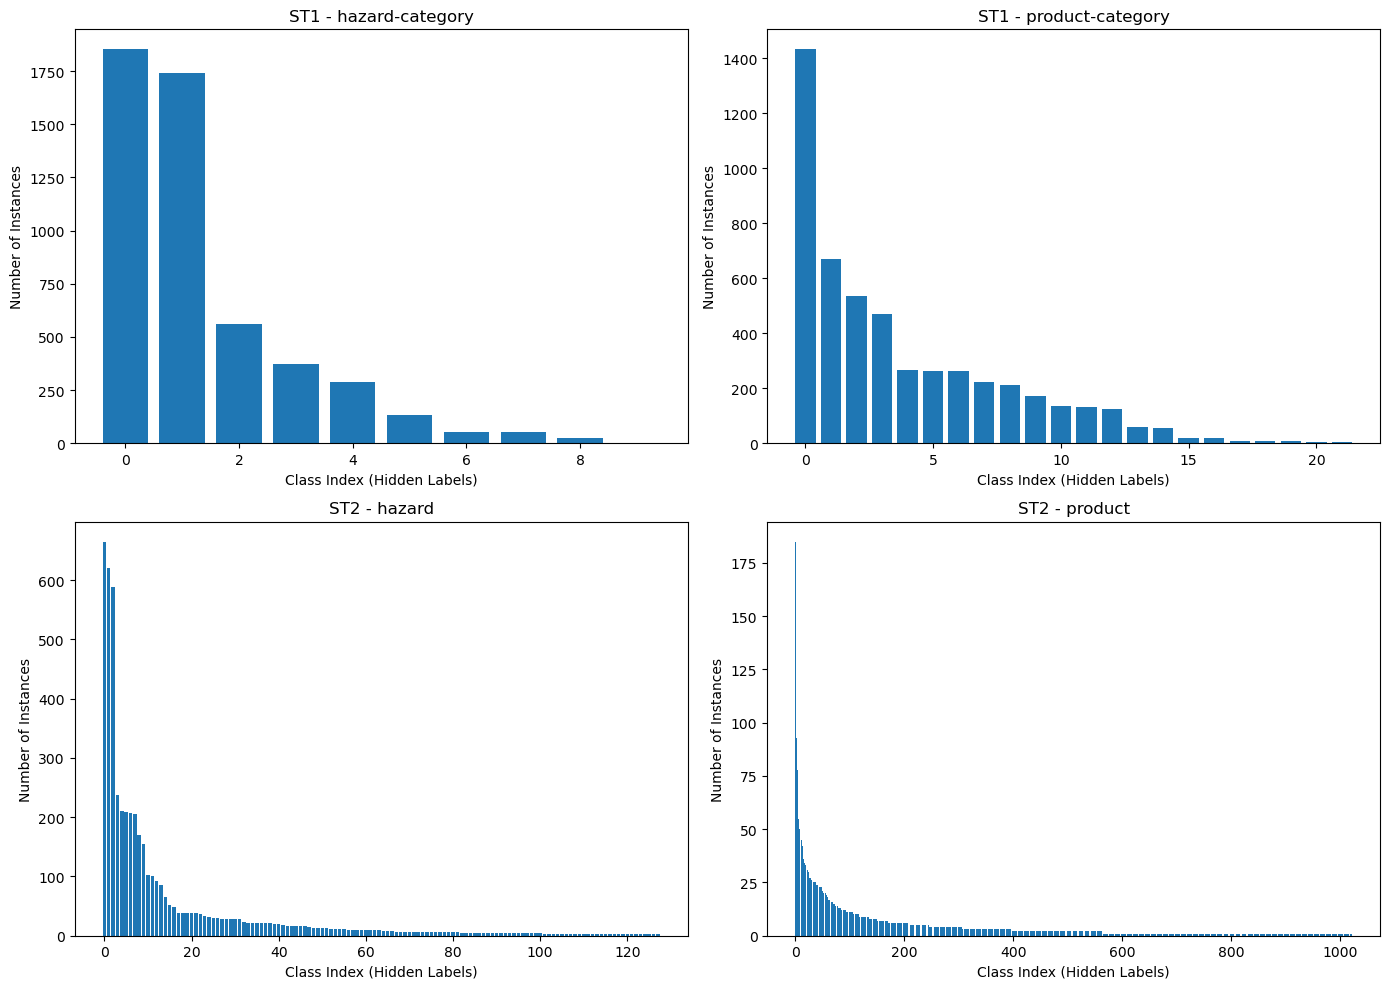

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

st1_columns = ["hazard-category", "product-category"]
st2_columns = ["hazard", "product"]

# Create figure and grid layout (2 rows, 2 columns)
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])  # 2x2 layout

# Titles for each section
titles = ["ST1", "ST1", "ST2", "ST2"]

# Loop through target categories and plot
for i, col in enumerate(target_columns):
    ax = plt.subplot(gs[i])
    
    if col in data.columns:
        value_counts = data[col].value_counts()
        ax.bar(range(len(value_counts)), value_counts.values)  # Use indices instead of labels

        ax.set_xlabel("Class Index (Hidden Labels)")
        ax.set_ylabel("Number of Instances")
        ax.set_title(f"{titles[i]} - {col}")  # Use ST1 for first two, ST2 for last two

# Adjust layout and show
plt.tight_layout()
plt.show()

The plots indicate a significant class imbalance across all four target categories. In the first task (Hazard-Category & Product-Category), a few dominant classes contain most instances, while others appear infrequently. The second task (Hazard & Product) exhibits an even more pronounced long-tail distribution, with numerous rare categories. Such imbalance can lead models to favor majority classes, reducing their ability to accurately predict minority ones.

## **Imbalanced data handling**

In order to handle class imbalance, two techniques were used: 
- data augmentation and 
- class weighting

Data augmentation was applied specifically to the rare classes to generate more samples and improve balance. Various approaches, including paraphrasing and back-translation, were explored. However, these methods did not yield the desired results. The paraphrasing approach often failed to generate meaningful variations, producing nearly identical sentences with some truncations at the end. Similarly, back-translation was ineffective in some cases, possibly due to the repetition of specific words, which in some cases caused the paraphrased text to also repeat those same terms. As a result, instead of improving the imbalance by increasing data for rare classes, these techniques introduced noise, ultimately hindering the model’s effectiveness.

Below are the code blocks, specifically the functions developed to perform data augmentation through paraphrasing. However, this notebook does not use these functions, as they were found to reduce the model's effectiveness. For this reason, any commands related to this data augmentation approach are commented out.

Additionally, several other models were tested for paraphrasing, but due to memory limitations, they could not be utilized effectively. These attempts are also commented out in the corresponding code blocks.  

### **1. Data Augmentation for minority class using LLM for Paraphrasing**

### 1.1 Find minority classes

The first step in data augmentation was identifying **rare classes** to generate artificial data through paraphrasing. To achieve this, the `get_rare_classes` function was developed.  

More specifically, this function **calculates the relative frequency of each class**, identifies classes that appear in less than a given threshold (default: 1%), and returns them as a list. These rare classes were the focus of the paraphrasing process.  

In [36]:
def get_rare_classes(df, column, threshold=0.01):
    class_counts = df[column].value_counts(normalize=True)
    rare_classes = class_counts[class_counts < threshold].index.tolist()
    print(rare_classes)
    return rare_classes

### 1.2 Create Synthetic Instances for Each Instance of Minority Classes  

After detecting rare classes, the next step was to **generate synthetic instances** by paraphrasing each sample in the minority classes. This was done using **`google/flan-t5-large`**, a **pre-trained transformer model developed by Google**. This model is based on the **T5 (Text-To-Text Transfer Transformer) architecture**, designed for various NLP tasks, including text generation, translation, and paraphrasing.  

The goal of paraphrasing is to **create variations of existing text while preserving its meaning**, allowing the model to learn from more diverse examples of underrepresented classes.  

More specifically, the `paraphrase_text`:  

- Tokenizes the text and handles potential issues like empty inputs.  
- Uses a prompt to generate the rephrasing while preserving meaning.  
- Generates a paraphrased version using settings that ensure diversity and readability.  
- Produces one paraphrased instance per rare class sample by default.  

In [37]:
def paraphrase_text(text, label):

    # Check if GPU is available and select device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model and tokenizer
    model_name = "google/flan-t5-large"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Move the model to the GPU
    model = model.to(device)

    input_text = f"Rephrase the following while keeping the same meaning focusing on {label}: {text}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    if input_ids.shape[1] == 0:
        print("Empty input_ids. Skipping generation.")
        return text  # Return the original text if tokenization fails

    # Move inputs to the same device as the model
    input_ids = input_ids.to(model.device)

    # Generate paraphrased text
    output = model.generate(input_ids, max_length=min(512, input_ids.shape[1] + 50), length_penalty=1,
                            temperature=0.9, top_k=30, num_beams=5, do_sample=True)

    print(f"Raw output: {output}")

    # Decode generated text
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [38]:
# # Check if GPU is available and select device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the model and tokenizer
# model_name = "google/flan-t5-large"
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = T5ForConditionalGeneration.from_pretrained(model_name)

# # Move the model to the GPU
# model = model.to(device)

More powerful models were tested as they handle the given prompt more effectively. However, they required too many resources (RAM) and could not be loaded:  

- **meta-llama/Llama-3.2-1B-Instruct**  
- **mistralai/Mistral-7B-Instruct-v0.1**  
- **microsoft/Phi-3-mini-4k-instruct**  


In [39]:
# text = 'Withdrawal of Various Nylon Kitchen Utensils due to Chemical Migration above the EU legal limit Tweet Thursday, 7 May 2020 Summary Category 2: For Information Alert Notification: 2020.25 Product: Please refer to table below for details. Batch Code: Please refer to table below for details. Country Of Origin: Unknown Message: The\xa0implicated batches of nylon kitchen utensils detailed below are being withdrawn from sale. These affected utensils\xa0will give rise to the leaching into food of chemicals (primary aromatic amines) above the EU legal limit.\xa0\xa0 Health affects are not expected from using these nylon kitchen utensils.\nWithdrawal of Various Nylon Kitchen Utensils due to Chemical Migration above the EU legal limit Tweet Thursday, 7 May 2020 Summary Category 2: For Information Alert Notification: 2020.25 Product: Please refer to table below for details. Batch Code: Please refer to table below for details. Country Of Origin: Unknown Message: The\xa0implicated batches of nylon kitchen utensils detailed below are being withdrawn from sale. These affected utensils\xa0will give rise to the leaching into food of chemicals (primary aromatic amines) above the EU legal limit.\xa0\xa0 Health affects are not expected from using these nylon kitchen utensils.'

# input_text = f"Extract useful tags from the following text: {text}. Return the output in a list separated by commas."

# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
# input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# input_ids = input_ids.to(model.device)

# output = model.generate(input_ids, max_new_tokens=1000, do_sample=True)

# output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# print(f'original text: {text}\n')

# print(f'paraphrased text:  {output_text}')

Finally, to integrate all the functions and automate the data augmentation process, `generate_synthetic_instances` function:  

- Identifies rare classes using `get_rare_classes`.  
- Generates paraphrased instances for rare-class samples with `paraphrase_text`.  
- Expands the dataset by adding the newly generated synthetic samples.  


In [40]:
def generate_synthetic_instances(train_df, label):

    rare_classes = get_rare_classes(train_df, label)

    augmented_samples = []
    for _, row in train_df.iterrows():
        if row[label] in rare_classes:  # Define rare_classes based on class distribution
            print(f'... Generating Synthetic data for {row[label]} class ...')
            print(f"Original: {row['text']}")
            new_text = paraphrase_text(row["text"], row[label])
            print(f"Paraphrased: {new_text}")
            augmented_samples.append({"text": new_text, label: row[label]})
    # Append to the original dataset
    train_df = pd.concat([train_df, pd.DataFrame(augmented_samples)], ignore_index=True)

    return train_df

### **2. Class Weights**

Since the data augmentation approach did not yield the desired results, the next approach involved using **class weights**. Given that the dataset is imbalanced, this method helps by **assigning higher importance to underrepresented classes**, allowing the model to learn from them more effectively and preventing it from being biased toward majority classes.  

The following function calculates class weights using **scikit-learn's `compute_class_weight`**, converts them into a PyTorch tensor, and applies a logarithmic transformation to smooth extreme weight differences. If a GPU is available, the weights are moved to CUDA for efficient computation.

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import torch

def calculate_class_weights(train_df):
  # Compute class weights
  class_weights = compute_class_weight(
      class_weight="balanced",
      classes=np.unique(train_df["label"]),
      y=train_df["label"]
  )




  # Convert to a tensor and move to GPU if available
  class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

  class_weights = torch.log1p(class_weights)


  # print("Class Weights:", class_weights)
  return class_weights

## **Feature Extraction**

Even though the text column provides the most valuable information for classification, handling large amounts of text efficiently is crucial. **Feature extraction** transforms raw text into structured representations, capturing essential patterns while reducing complexity. This helps improve model performance by focusing on the most relevant parts of the text rather than processing entire passages.  

For this approach, two key steps are followed:  

- **Load spaCy's English NER model** to extract Named Entity Recognition (NER) tags, identifying key entities in the text.  
- **Use TF-IDF** to determine the most important words, assigning higher weights to words that appear frequently in a document but less frequently across all documents.  

### **1. Load spaCy's English NER model to extract NER tags**

In [10]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_ner_tags(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]  # Get entity labels
    return " ".join(entities) if entities else "O"  # "O" for no entity


### **2. Use TDIDF to identify important words in the text**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Use top 100 words

def extract_tfidf_features(texts, n=50):
    vectorizer = TfidfVectorizer(max_features=n, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Convert to DataFrame with unique column names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{word}" for word in feature_names])
    return tfidf_df


## **Data preparation**

Before training a classification model, the text data must be properly processed to ensure it is structured and optimized for learning. This section covers the **data preparation pipeline**, which consists of two main functions:

- **Tokenization Function:** Converts raw text into numerical input suitable for transformer models.
- **Data Preparation Function:** Prepares the dataset by extracting features, applying transformations, and formatting it for training.

### **Why Use Transformers?**  
Traditional models like RNNs and LSTMs process text one word at a time, making them slow and less effective at capturing long-range dependencies. As sentences grow longer, they struggle to retain important context.  

Transformers solve this with **self-attention**, which allows them to analyze all words in a sentence at once and focus on the most relevant ones. This makes them highly effective for NLP tasks like text classification.  

**Transformers Key Advantages:**  
- **Better context understanding** by considering all words at once.  
- **Faster processing** through parallel computation.  

Because of these advantages, a transformer-based model was chosen.

### **Model Selection: RoBERTa**

For tokenization and modeling, **RoBERTa** was chosen as the transformer model. RoBERTa is an improved version of BERT, designed to enhance performance by removing the next-sentence prediction objective and training on more data with longer sequences.

Initially, **DeBERTa** was considered as the first choice, as it typically outperforms RoBERTa by utilizing a more advanced self-attention mechanism and an improved representation of word relationships. However, DeBERTa required significantly more memory and GPU resources, leading to computational constraints. As a result, RoBERTa was selected as a balance between strong performance and feasible resource requirements.


### **1.Tokenization**

In [12]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

### **2. Data Preparation Function**

The **`prepare_data`** function processes the dataset and returns PyTorch **DataLoaders** for training and validation, along with a label encoder.
In more detail: 
- **TF-IDF Feature Extraction** – Calls **`extract_tfidf_features`** to highlight important words.  
- **Named Entity Recognition (NER) Tags** – Calls **`extract_ner_tags`** to identify key entities and append them to the text.  
- **Tokenization** – Uses **RoBERTa's tokenizer** via **`tokenize_function`** to prepare text for the model.  
- **Merging Features** – Combines TF-IDF features and NER tags with the original text.  
- **Data Formatting** – Converts the dataset into a Hugging Face **Dataset** and structures it for **PyTorch DataLoaders**.  
- **Data Collation** – Uses **`DataCollatorWithPadding`** to ensure consistent input size.  

In [13]:
def prepare_data(label, train_df, dev_df):

    # Extract TF-IDF features
    train_tfidf = extract_tfidf_features(train_df['text'])
    dev_tfidf = extract_tfidf_features(dev_df['text'])

    # Extract NER tags
    train_df['ner_tags'] = train_df['text'].apply(extract_ner_tags)
    dev_df['ner_tags'] = dev_df['text'].apply(extract_ner_tags)

    # Combine text, keywords, and NER tags
    train_df['text'] = train_df['text'] + " " + train_df['ner_tags']
    dev_df['text'] = dev_df['text'] + " "  + dev_df['ner_tags']

    # Merge TF-IDF features with the main dataframe
    train_df = pd.concat([train_df.reset_index(drop=True), train_tfidf.reset_index(drop=True)], axis=1)
    dev_df = pd.concat([dev_df.reset_index(drop=True), dev_tfidf.reset_index(drop=True)], axis=1)

    # Convert DataFrame to Hugging Face Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    # Apply the tokenizer
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=512)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return (
        DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator),
        DataLoader(dev_dataset, batch_size=8, collate_fn=data_collator),
        label_encoder
    )



## **Training**

 After data preparation, this section focuses on training the model. Since training is required for each target column (two per subtask), a function was developed to avoid repetition. More specifically, the **`train_model`** function:  

- **Optimizes model performance** by performing gradient updates—computing the loss, backpropagating errors, and adjusting model weights to improve predictions.  
- **Uses class weights (if enabled)** to handle imbalanced data.  
- **Applies a learning rate scheduler** for smoother convergence.  
- **Processes batches efficiently** using `AdamW` optimizer and GPU acceleration. 

In [14]:
from tqdm.auto import tqdm
import torch.nn as nn

def train_model(model, train_dataloader, class_weights, use_weights=False):

    if use_weights:
      # loss function with class weights
      loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=5e-5)

    num_epochs = 3
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    model.train()

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
            outputs = model(**batch)
            if use_weights:
              loss = loss_fn(outputs.logits, batch["labels"])  # Use weighted loss
            else:
              loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

## **Evaluation**

After training, the model needs to be evaluated to measure its performance. Since this step has to be performed for each target column, a function was developed to handle the process efficiently and avoid repeating code.  

In more detail the following function:

- **Switches to evaluation mode**  
  Turns off training-specific settings like dropout for stable predictions.  
- **Runs inference without updating weights**  
  Processes the validation set without modifying the model.  
- **Predicts the most likely class**  
  Selects the class with the highest probability.  
- **Translates model outputs into category names**  
  Converts numerical predictions into understandable labels.  
- **Evaluates performance**  
  Compares predictions with actual labels and generates a report.  


In [15]:
def evaluate_model(model, dev_dataloader, label_encoder):
    model.eval()
    total_predictions = []
    with torch.no_grad():
        for batch in dev_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_predictions.extend([p.item() for p in predictions])

    predicted_labels = label_encoder.inverse_transform(total_predictions)
    gold_labels = label_encoder.inverse_transform(dev_df.label.values)
    print(classification_report(gold_labels, predicted_labels, zero_division=0))

    # dev_df['predictions-hazard-category'] = predicted_labels

    return gold_labels, predicted_labels

In [60]:
def evaluate_model_unseen_cases(model, dev_dataloader, label_encoder):
    model.eval()
    total_predictions = []

    with torch.no_grad():
        for batch in dev_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_predictions.extend([p.item() for p in predictions])

    # Convert numerical predictions back to labels
    label_classes = list(label_encoder.classes_) + ["Unknown"]  # Add "Unknown" label

    print(label_classes)

    predicted_labels = [
        label_classes[p] if p < len(label_encoder.classes_) else "Unknown"
        for p in total_predictions
    ]
    print(label_classes)

    gold_labels = [
        label_classes[l] if l < len(label_encoder.classes_) else "Unknown"
        for l in dev_df.label.values
    ]
    print(gold_labels)

    print(classification_report(gold_labels, predicted_labels, zero_division=0))

    return gold_labels, predicted_labels


Every class present in the test set but not in the training set is assigned the label **"Unknown"** to ensure proper label encoding. This approach creates a new class that groups all labels that do not exist in both the training and test sets simultaneously.  

The overall procedure follows a similar approach to a general evaluation method, where the model is set to evaluation mode, predictions are made on the development dataset, and results are compared with the true labels. The key difference is the handling of unseen classes by introducing the **"Unknown"** label to maintain consistency in label encoding.

In [16]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

In [49]:
dev_df = pd.read_csv('data/incidents_test.csv', index_col=0, encoding='utf-8')

## **ST1**

For ST1 calculation, although the diagram above indicated that the target columns were imbalanced and class weighting was introduced to address this issue, testing revealed that this approach led to lower model effectiveness.

In contrast, without class weighting, the model achieved higher scores. This may be due to the increased emphasis on rare classes, which had fewer instances. As a result, the model’s performance on the more frequent classes—where initial scores were already high—dropped due to the redistribution of focus toward the rarer ones. 

For this reason, ST1 is calculated in this part without applying the class weighting method.

- ### **Hazard Category**  

In [50]:
label = 'hazard-category'
# train_df, dev_df = train_test_split(data, test_size=0.2, random_state=2024, stratify=data[label])
train_df = data.copy()

# train_df["text"] = train_df["text"].apply(clean_text)

# train_df = generate_synthetic_instances(train_df, label)

label_encoder = LabelEncoder()
label_encoder.fit(data[label])

train_df['label'] = label_encoder.transform(train_df[label])
dev_df['label'] = label_encoder.transform(dev_df[label])

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataloader, dev_dataloader, label_encoder = prepare_data(label, train_df, dev_df)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(data[label].unique()))
model.to('cuda')  # Move model to GPU if available

class_weights = calculate_class_weights(train_df)
train_model(model, train_dataloader, class_weights, False)
actual_hc, predicted_hc = evaluate_model(model, dev_dataloader, label_encoder)

dev_df['predictions-hazard-category'] = predicted_hc

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1908 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


                                precision    recall  f1-score   support

                     allergens       0.96      0.97      0.97       365
                    biological       0.99      0.98      0.99       343
                      chemical       0.93      0.96      0.94        52
food additives and flavourings       1.00      0.50      0.67         4
                foreign bodies       0.97      1.00      0.98       111
                         fraud       0.81      0.75      0.78        75
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.83      1.00      0.91        10
                  other hazard       0.74      0.77      0.75        26
              packaging defect       0.90      0.90      0.90        10

                      accuracy                           0.95       997
                     macro avg       0.81      0.78      0.79       997
                  weighted avg       0.95      0.95      0.95 

- ### **Product-Category**

In [51]:
label = 'product-category'
# train_df, dev_df = train_test_split(data, test_size=0.2, random_state=2024, stratify=data[label])
train_df = data.copy()

# train_df["text"] = train_df["text"].apply(clean_text)

# train_df = generate_synthetic_instances(train_df, label)

label_encoder = LabelEncoder()
label_encoder.fit(data[label])

train_df['label'] = label_encoder.transform(train_df[label])
dev_df['label'] = label_encoder.transform(dev_df[label])

train_dataloader, dev_dataloader, label_encoder = prepare_data(label, train_df, dev_df)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(data[label].unique()))
model.to('cuda')

class_weights = calculate_class_weights(train_df)
train_model(model, train_dataloader, class_weights, False)
actual_pc, predicted_pc = evaluate_model(model, dev_dataloader, label_encoder)

dev_df['predictions-product-category'] = predicted_pc

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1908 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      0.94      0.97        16
                      cereals and bakery products       0.75      0.76      0.75       121
     cocoa and cocoa preparations, coffee and tea       0.77      0.86      0.81        42
                                    confectionery       0.70      0.48      0.57        33
dietetic foods, food supplements, fortified foods       0.58      0.58      0.58        26
                                    fats and oils       0.80      0.67      0.73         6
                   food additives and flavourings       0.00      0.00      0.00         4
                            fruits and vegetables       0.73      0.75      0.74       103
                                 herbs and spices       0.50      0.40      0.44        20
                            honey and royal jelly       1.00      0.50      0.67         

### **ST1 Evaluation**

In [52]:
score = compute_score(
    actual_hc, actual_pc,
    predicted_hc, predicted_pc
)
print(f"Score Sub-Task 1: {score:.3f}")

Score Sub-Task 1: 0.715


### **Review of Sub-Task 1**
The classification performance for Sub-Task 1, with an overall score of 0.715, highlights the challenges posed by class imbalance in the dataset. Instead of relying on accuracy, the macro-averaged f1-score provides a clearer picture of how well the model performs across all categories, including both frequent and rare ones.

For hazard classification, the macro f1-score is 0.79, indicating strong performance for dominant classes like allergens, biological, and foreign bodies but much weaker recognition for rare categories. Classes such as migration and food additives and flavourings have an f1-score of zero, demonstrating that the model fails to correctly classify them.

Similarly, for product category classification, the macro f1-score is 0.64, reinforcing the same issue. While the model performs well in categories like meat, egg and dairy products, seafood, and alcoholic beverages, it struggles significantly with underrepresented classes such as food additives and flavourings, sugars and syrups, and other food product/mixed, which also have zero f1-score.

The low macro f1-score in both tasks highlights the effect of data imbalance, as the model is biased toward frequent categories while performing poorly on rare ones. 

## **ST2**

- ### **Hazard**  

In [53]:
label = 'hazard'
# train_df, dev_df = train_test_split(data, test_size=0.2, random_state=2024, stratify=data[label])
train_df = data.copy()

# train_df["text"] = train_df["text"].apply(clean_text)

# train_df = generate_synthetic_instances(train_df, label)

label_encoder = LabelEncoder()
label_encoder.fit(data[label])

train_df['label'] = label_encoder.transform(train_df[label])
dev_df['label'] = label_encoder.transform(dev_df[label])

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataloader, dev_dataloader, label_encoder = prepare_data(label, train_df, dev_df)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(data[label].unique()))
model.to('cuda')

class_weights = calculate_class_weights(train_df)
train_model(model, train_dataloader, class_weights, False)
actual_h, predicted_h = evaluate_model(model, dev_dataloader, label_encoder)

dev_df['predictions-hazard'] = predicted_h

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1908 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


                                                 precision    recall  f1-score   support

                                      Aflatoxin       1.00      0.50      0.67         2
                                 abnormal smell       0.00      0.00      0.00         1
                                alcohol content       0.00      0.00      0.00         1
                                      alkaloids       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         3
                                         almond       0.92      0.85      0.88        13
                                      amygdalin       0.00      0.00      0.00         1
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       0.75      1.00      0.86         3
                           bad smell / off odor       0.00      0.00      0.00         1
                    

- ### **Product**  

In [69]:
unseen_classes = []
for x in dev_df['product'].unique():
    if x not in data['product'].unique():
        unseen_classes.append(x)

In [70]:
len(unseen_classes)

82

In [71]:
len(dev_df['product'].unique())

447

Transform labels safely, mapping unseen labels to 'Unknown'

In [54]:
def safe_transform(label_encoder, labels):
   
    known_labels = set(label_encoder.classes_)
    transformed_labels = []
    for label in labels:
        if label in known_labels:
            transformed_labels.append(label_encoder.transform([label])[0])
        else:
            transformed_labels.append(len(known_labels))  # Assign new index for unknown labels
    return transformed_labels


In [17]:
label = 'product'

train_df, dev_df = train_test_split(data, test_size=0.2, random_state=2024) # stratify=data[label]
#train_df = data.copy()

# train_df["text"] = train_df["text"].apply(clean_text)

# train_df = generate_synthetic_instances(train_df, label)


label_encoder = LabelEncoder()
label_encoder.fit(data[label])

train_df['label'] = label_encoder.transform(train_df[label])
dev_df['label'] = label_encoder.transform(dev_df[label])
#dev_df['label'] = safe_transform(label_encoder, dev_df[label])  # Unseen labels -> len(train.unique)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataloader, dev_dataloader, label_encoder = prepare_data(label, train_df, dev_df)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(data[label].unique()))
model.to('cuda')

class_weights = calculate_class_weights(train_df)
train_model(model, train_dataloader, class_weights, False)

#actual_p, predicted_p = evaluate_model_unseen_cases(model, dev_dataloader, label_encoder)
actual_p, predicted_p = evaluate_model(model, dev_dataloader, label_encoder)

#dev_df['predictions-product'] = predicted_p

Map:   0%|          | 0/4065 [00:00<?, ? examples/s]

Map:   0%|          | 0/1017 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1527 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


                                                                        precision    recall  f1-score   support

                                                Catfishes (freshwater)       0.00      0.00      0.00         2
                                                 Fishes not identified       0.00      0.00      0.00         5
                                                    Groupers (generic)       0.00      0.00      0.00         1
                                              Not classified pork meat       0.00      0.00      0.00         1
                                            Pangas catfishes (generic)       0.00      0.00      0.00         1
                                   Precooked cooked pork meat products       0.00      0.00      0.00         3
                                    Torpedo-shaped catfishes (generic)       0.00      0.00      0.00         1
                                                       adobo seasoning       0.00      0.00      0.00  

While running using incidents_train.csv and train_test_split everything was fine, but while using the labelled test set there is a issue with unseen classes

In [25]:
score = compute_score(
    actual_h, actual_p,
    predicted_h, predicted_p
)
print(f"Score Sub-Task 2: {score:.3f}")

Score Sub-Task 2: 0.193


### **Review of Sub-Task 2**

The classification results for Sub-Task 2 reveal significant challenges, particularly in **product classification**, where the **macro-averaged f1-score is 0.00**. This indicates that the model fails to correctly classify any product category, with almost all categories receiving **zero precision, recall, and f1-score**. The **accuracy is only 4%**, meaning the model is largely ineffective in distinguishing between different product types. The poor performance can be attributed to **extreme class imbalance**, where some categories have very few examples, making it difficult for the model to learn meaningful patterns. Additionally, the model might not generalize well due to **insufficient training data for certain product types**. Addressing this issue would require **better data balancing, augmentation techniques, or an alternative classification approach**.

For **hazard classification**, the model performs slightly better, with a **macro-averaged f1-score of 0.43** and an **accuracy of 84%**. However, the **macro f1-score remains low**, indicating **poor performance on less frequent hazards**. While categories like **bone fragment (f1-score: 1.00), clostridium botulinum (f1-score: 0.94), and cereals containing gluten (f1-score: 0.82)** are well classified, many other hazard types—including **abnormal smell, alcohol content, allergens, and several chemical hazards—have an f1-score of zero**, showing that the model completely fails to identify them. This imbalance suggests that **the model is biased toward more frequent hazard types** while ignoring rare but important ones. 

In [81]:
dev_df[['predictions-hazard-category', 'predictions-product-category', 'predictions-hazard']].to_csv('submission.csv')